Data from: https://www.kaggle.com/kondla/carinsurance

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.linear_model import LogisticRegression

%matplotlib inline

In [125]:
df = pd.read_csv('carinsurance_train.csv')

In [126]:
df.isnull().sum()

Id                     0
Age                    0
Job                   19
Marital                0
Education            169
Default                0
Balance                0
HHInsurance            0
CarLoan                0
Communication        902
LastContactDay         0
LastContactMonth       0
NoOfContacts           0
DaysPassed             0
PrevAttempts           0
Outcome             3042
CallStart              0
CallEnd                0
CarInsurance           0
dtype: int64

In [127]:
# Dropping columns and nulls
df.dropna(subset = ['Job','Education'],inplace=True)
df.drop(['Outcome','Communication','Id'],axis=1,inplace=True)

In [128]:
df.head()

,Age,Job,Marital,Education,Default,Balance,HHInsurance,CarLoan,LastContactDay,LastContactMonth,NoOfContacts,DaysPassed,PrevAttempts,CallStart,CallEnd,CarInsurance
0,32,management,single,tertiary,0,1218,1,0,28,jan,2,-1,0,13:45:20,13:46:30,0
1,32,blue-collar,married,primary,0,1156,1,0,26,may,5,-1,0,14:49:03,14:52:08,0
2,29,management,single,tertiary,0,637,1,0,3,jun,1,119,1,16:30:24,16:36:04,1
3,25,student,single,primary,0,373,1,0,11,may,2,-1,0,12:06:43,12:20:22,1
4,30,management,married,tertiary,0,2694,0,0,3,jun,1,-1,0,14:35:44,14:38:56,0


In [129]:
# Timestamp modifications
temp = pd.to_datetime(df['CallEnd'])- pd.to_datetime(df['CallStart'])
df['Call Duration'] = [x.seconds/60 for x in temp]
df['Call hour'] = [x.hour for x in pd.to_datetime(df['CallStart'])]
df.drop(['CallStart','CallEnd'],axis=1,inplace=True)

In [130]:
# Engineering a feature to signify whether a customer had been contacted before
df['NotContactedBefore'] = df['DaysPassed'].apply(lambda x: 1 if x==-1 else 0)

In [131]:
# Engineering busy and easy months

df['busy_month'] = df['LastContactMonth'].apply(lambda x:1 if x in ['dec','mar','oct','sep'] else 0)
df['easy_month'] = df['LastContactMonth'].apply(lambda x:1 if x in ['aug','jan','jul','jun','may','nov'] else 0)


In [132]:
# Dropping last contact month
df.drop('LastContactMonth',axis=1 , inplace=True)


In [133]:
# Replacing education with ordinal numerical features
df.replace({v:k for k,v in enumerate(['primary','secondary','tertiary'])},inplace=True)

In [134]:
# Getting dummies for categorical features
df = pd.get_dummies(df,columns = ['Job','Marital'],drop_first=True)

In [159]:
def train_model(model,param_grid):   
    gsc = GridSearchCV(model,param_grid = param_grid)
    gsc.fit(X_train,y_train)
    y_pred = gsc.predict_proba(X_test)[:,1]
    print(f'AUC SCore {roc_auc_score(y_test,y_pred)}')
    return model.set_params(**gsc.best_params_), y_pred

In [160]:
# Baseline model
X_cols = df.drop('CarInsurance',axis=1).columns
X,y  = df.drop('CarInsurance',axis=1), df['CarInsurance'].values

ss = RobustScaler()
X = ss.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, stratify = y)

#rf = 
param_grid = {'n_estimators':np.arange(10,100,10),'max_depth':np.arange(1,8) }
rf,y_pred = train_model(RandomForestClassifier(),param_grid)

# gsc = GridSearchCV(rf,param_grid = param_grid)
# gsc.fit(X_train,y_train)
# y_pred = gsc.predict_proba(X_test)[:,1]
# print(f'AUC SCore {roc_auc_score(y_test,y_pred)}')

AUC SCore 0.918201754385965


In [161]:
# Showing feature importance
#rf = rf.set_params(**gsc.best_params_)
rf.fit(X_train,y_train)
sorted(list(zip(X_cols,rf.feature_importances_)), key = lambda x: x[1], reverse = True)[:5]

[('Call Duration', 0.45287468834233147),
 ('busy_month', 0.07636003367984816),
 ('Age', 0.05918792843815998),
 ('DaysPassed', 0.05800902917733756),
 ('easy_month', 0.05080559398981709)]

In [162]:
def plot_auc_pr_curve(y_test,y_pred):
    plt.figure()
    fp, tp, _ = roc_curve(y_test,y_pred)
    plt.plot(fp,tp);
    plt.xlabel('False Positive');
    plt.ylabel('True Positive');
    plt.title('AUC Curve')

    plt.figure()
    precision, recall, _ = precision_recall_curve(y_test,y_pred)
    plt.plot(recall, precision);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    plt.title('Recall-Precision')

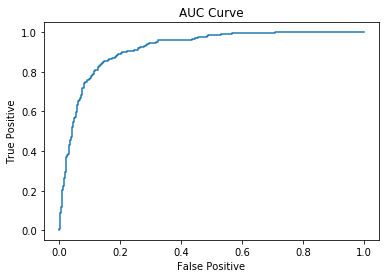

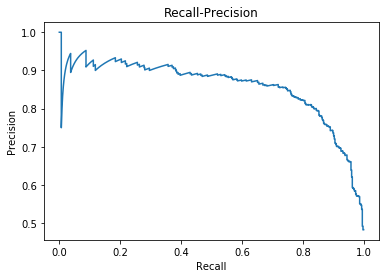

In [163]:
plot_auc_pr_curve(y_test,y_pred)

In [166]:
param_grid = {'n_estimators':np.arange(10,100,10),'learning_rate':np.arange(0.05,0.15,0.02)}
gb,y_pred = train_model(GradientBoostingClassifier(),param_grid)
gb.fit(X_train,y_train)
sorted(list(zip(X_cols,gb.feature_importances_)), key = lambda x: x[1], reverse = True)[:5]

AUC SCore 0.9241609458428681


[('Call Duration', 0.30175559393894164),
 ('DaysPassed', 0.09624909700524314),
 ('Age', 0.08763629357703845),
 ('LastContactDay', 0.08163015064133702),
 ('Balance', 0.06955963273711457)]

In [167]:
param_grid = {'n_estimators':np.arange(10,100,10),'learning_rate':np.arange(0.05,0.15,0.02)}
adaboost,y_pred = train_model(AdaBoostClassifier(),param_grid)
adaboost.fit(X_train,y_train)
sorted(list(zip(X_cols,adaboost.feature_importances_)), key = lambda x: x[1], reverse = True)[:5]

AUC SCore 0.9149678998220188


[('Call Duration', 0.4),
 ('HHInsurance', 0.1),
 ('Age', 0.06666666666666667),
 ('easy_month', 0.06666666666666667),
 ('DaysPassed', 0.05555555555555555)]

In [186]:
param_grid = {'penalty':['l1','l2'],'C':np.arange(0.1,1,0.1)}
log_reg,y_pred = train_model(LogisticRegression(),param_grid)
log_reg.fit(X_train,y_train)
sorted(list(zip(X_cols,log_reg.coef_[0])), key = lambda x: x[1], reverse = True)[:5]

AUC SCore 0.9078311721332317


[('Call Duration', 1.7069754872436338),
 ('busy_month', 1.060910817413623),
 ('Job_retired', 0.57031097514249),
 ('Marital_single', 0.35215032529500917),
 ('Education', 0.26032742234156503)]

In [195]:
voting = VotingClassifier([('log_reg',log_reg),('rf',rf),('gb',gb),('ada',adaboost)],voting='soft')


AUC Score 0.9242308670226289


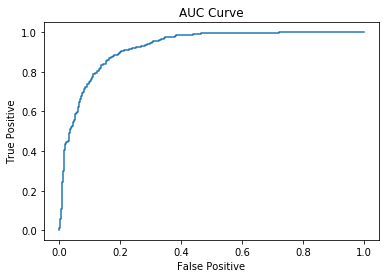

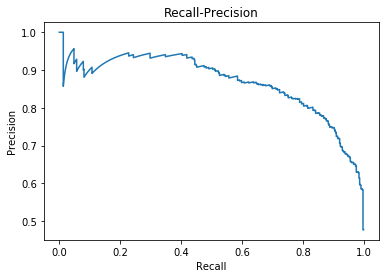

In [196]:
voting.fit(X_train,y_train)
y_pred = voting.predict_proba(X_test)[:,1]
print(f'AUC Score {roc_auc_score(y_test,y_pred)}')
plot_auc_pr_curve(y_test,y_pred)